In [29]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
G = nx.Graph()

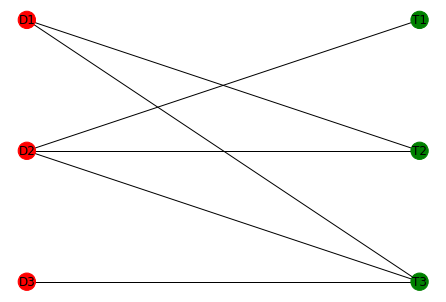

In [2]:
G.add_nodes_from([('D1',{"color":"green"}), 'D2', 'D3', 'T1', 'T2', 'T3'])
G.add_edges_from([('D1', 'T2', {'weight': 1}),('D1', 'T3', {'weight': 3}), ('D2', 'T1', {'weight': 5}),('D2', 'T2', {'weight': 6}),('D2', 'T3', {'weight': 4}),('D3', 'T3', {'weight': 2})])
nx.draw(G, nx.bipartite_layout(G,['D1', 'D2', 'D3']), node_color = ['red', 'red', 'red','green','green','green'], with_labels=True)


[('D1', 'T2'), ('T2', 'D2'), ('D2', 'T3')]
21.0


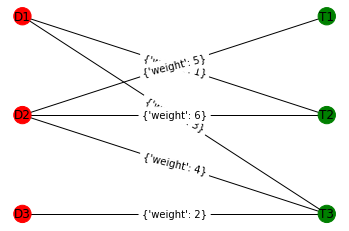

In [3]:
pos = nx.bipartite_layout(G,['D1', 'D2', 'D3'])
_edge_labels = nx.draw_networkx_edge_labels(G,pos)
labels = nx.get_edge_attributes(G,'pos')
nx.draw(G,pos,node_color = ['red', 'red', 'red','green','green','green'], with_labels=True)
#nx.draw_networkx_edge_labels(G,pos,edge_labels= _edge_labels)

max_path = max((path for path in nx.all_simple_edge_paths(G, "D1", "T3")), key=lambda path:  G.size(weight="weight"))
print(max_path)
print(G.size(weight="weight"))

For my next trick, I will try to:\
    - create random datasets to calculate on\
    - implement a greedy choice algorithm for transformed graphs\
    - create an algorithm to trandsom the data into a transformed graph

In [50]:
class Trajectory:
    def __init__(self,_id, _donor, _target, _value, _risk=0):
        self.id = _id
        self.donor = _donor
        self.target = _target
        self.value = _value
        self.risk = _risk
        self.collisions = []
    
    def add_collision(self, trajectory):
        self.collisions.append(trajectory)
        
    def __str__(self):
        return str(self.id) + ": "+ self.donor + "-->" + self.target + "  Value " + str(self.value) + " "

#Data is created in the following way: Amount is given and the function returns the nodes and trajectories between these.
#Also returns collisions with given collision rate
def create_data(no_donors, no_targets, no_trajectories, collision_rate=0 ):
    donors = []
    targets = []
    trajectories = []
    for i in range(no_donors):
        donors.append("D" + str(i)) # name all donors
    for i in range(no_targets):
        targets.append("T"+str(i)) # name all targets
    for i in range(no_trajectories):
        trajectories.append(Trajectory(i, random.choice(donors), random.choice(targets),random.randint(0,10))) #a trejectory is remembered by a tuple of start and end
    
    for i in range(no_trajectories):
        for j in range(i, no_trajectories):
            if i !=j:
                if np.random.binomial(1,collision_rate):
                    #print("added trajectory for " + str(i) + " and" + str(j))
                    trajectories[i].add_collision(trajectories[j])
                    trajectories[j].add_collision(trajectories[i])
    
    
    return donors, targets, trajectories

def bipartite_graph(donors, targets, trajectories):
    g = nx.Graph()
    g.add_nodes_from(donors+ targets)
    for t in trajectories:
        g.add_edge(t.donor, t.target, weight=t.value)
    _node_color =[]
    for i in range(len(donors)):
        _node_color.append('green')
        
    for i in range(len(targets)):
        _node_color.append('red')
        
    nx.draw(g, nx.bipartite_layout(g,donors), node_color=_node_color, with_labels=True)
    
def mutually_exclusive_trajectories(t1, t2):
    if(t1.donor == t2.donor):
        return True
    if(t1.target == t2.target):
        return True
    if(t2 in t1.collisions):
        return True
    return False

def transform_graph(trajectories):
    G = nx.Graph()
    G.add_nodes_from(trajectories)
    for i in range(len(trajectories)):
        for j in range(i, len(trajectories)):
            if i != j:
                if mutually_exclusive_trajectories(trajectories[i], trajectories[j]):
                    G.add_edge(trajectories[i], trajectories[j])
    return G

added trajectory for 1 and3
added trajectory for 1 and6
added trajectory for 1 and8
added trajectory for 2 and8
added trajectory for 3 and4
added trajectory for 3 and5
added trajectory for 3 and9
added trajectory for 4 and8


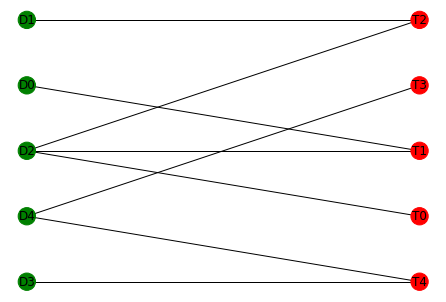

In [16]:
donors, targets, trajectories = create_data(5,5,10,0.1)
bipartite_graph(donors, targets, trajectories)

In [17]:
for i in range(len(trajectories)):
    print("\nTrajectory number: " + str(i))
    for t in trajectories[i].collisions:
        print(t, end = '')




Trajectory number: 0

Trajectory number: 1
3: D1-->T2  Value 3 6: D2-->T1  Value 3 8: D2-->T0  Value 6 
Trajectory number: 2
8: D2-->T0  Value 6 
Trajectory number: 3
1: D4-->T3  Value 10 4: D0-->T1  Value 8 5: D3-->T4  Value 4 9: D4-->T4  Value 9 
Trajectory number: 4
3: D1-->T2  Value 3 8: D2-->T0  Value 6 
Trajectory number: 5
3: D1-->T2  Value 3 
Trajectory number: 6
1: D4-->T3  Value 10 
Trajectory number: 7

Trajectory number: 8
1: D4-->T3  Value 10 2: D2-->T2  Value 5 4: D0-->T1  Value 8 
Trajectory number: 9
3: D1-->T2  Value 3 

nx.draw(transform_graph(trajectories))

In [18]:
for t in trajectories:
    print(t)

0: D3-->T4  Value 7 
1: D4-->T3  Value 10 
2: D2-->T2  Value 5 
3: D1-->T2  Value 3 
4: D0-->T1  Value 8 
5: D3-->T4  Value 4 
6: D2-->T1  Value 3 
7: D2-->T1  Value 5 
8: D2-->T0  Value 6 
9: D4-->T4  Value 9 


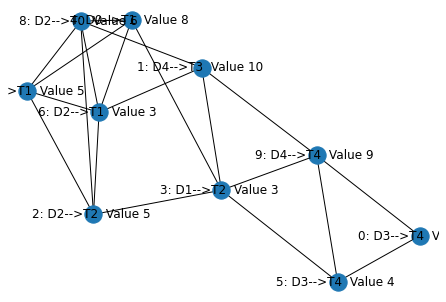

In [34]:
g = transform_graph(trajectories)
nx.draw(g, with_labels=True)


<h2> Now that the necessary datastructure manipulation , data generation and data visualisation are kinda done, it is time to actually implement some algorithms to find the "optimal" set of trajectories. <h2>

In [46]:
def greedy_trajectory_algorithm(graph):
    optimal_trajectories = []
    plt.figure()
    while graph.number_of_nodes() != 0:
        nodes = list(graph.nodes)
        max_node = max(nodes , key= lambda n : n.value)
        _node_colors = []
        for i in range(len(nodes)):
            if nodes[i] == max_node:
                _node_colors.append('green')
            elif nodes[i] in graph.neighbors(max_node):
                _node_colors.append('red')
            else:
                _node_colors.append('blue')
        nx.draw(graph, with_labels=True, node_color=_node_colors)
        optimal_trajectories.append(max_node)
        for n in list(graph.neighbors(max_node)):
            graph.remove_node(n)
        graph.remove_node(max_node)
        plt.show()
        inn = print(input("Continue?"))
        if inn == 'n':
            return
    return optimal_trajectories

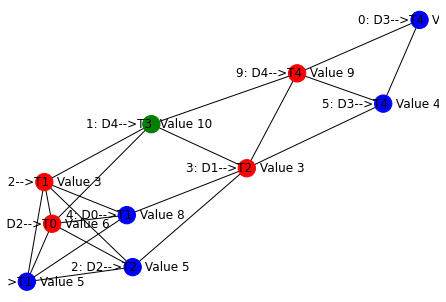

Continue?y
y


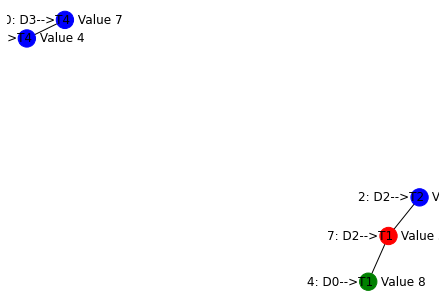

Continue?y
y


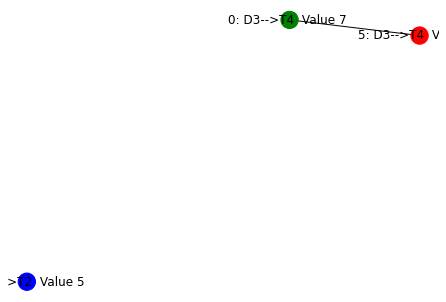

Continue?y
y


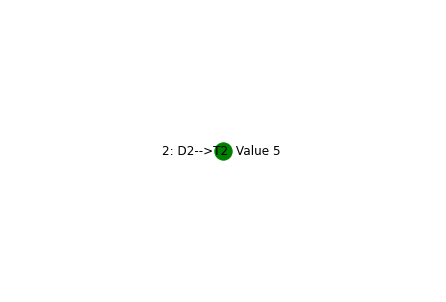

Continue?y
y
1: D4-->T3  Value 10 
4: D0-->T1  Value 8 
0: D3-->T4  Value 7 
2: D2-->T2  Value 5 


In [47]:
g = transform_graph(trajectories)
for t in greedy_trajectory_algorithm(g):
    print(t)


<h3>Simple example going from physically inspired graph to a more abstract transformed graphs where every node is a trajectory <h3>


Trajectory number: 0

Trajectory number: 1

Trajectory number: 2
3: D1-->T1  Value 3 
Trajectory number: 3
2: D0-->T2  Value 7 
Trajectory number: 4


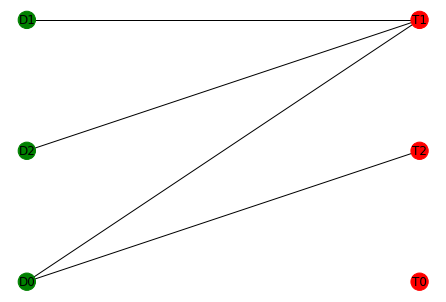

In [53]:
donors, targets, trajectories = create_data(3,3,5,0.1)
bipartite_graph(donors, targets, trajectories)
for i in range(len(trajectories)):
    print("\nTrajectory number: " + str(i))
    for t in trajectories[i].collisions:
        print(t, end = '')


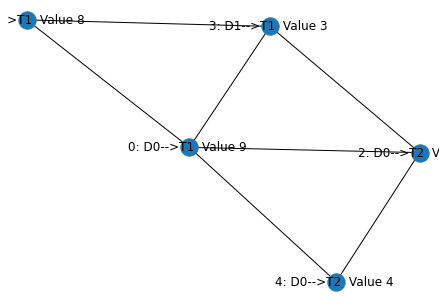

In [54]:
g = transform_graph(trajectories)
nx.draw(g, with_labels=True)
